In this notebook we are going to try to assess the performances of USAD, but considering exclusively one decoder, instead of two. The performances will be assessed on the SWAT dataset

In [1]:
%cd /nfs/home/medoro/Unsupervised_Anomaly_Detection_thesis

/nfs/home/medoro/Unsupervised_Anomaly_Detection_thesis


/nfs/home/medoro/Unsupervised_Anomaly_Detection_thesis/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from preprocessing import *
import preprocessing as prp
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as data_utils
#from USAD.usad import *
#from linear_ae import *
from convolutional_ae import *
#from lstm_ae import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score
from postprocessing import *
import plotly.graph_objects as go
#from USAD.usad_conv import *
from utils_ae import *

import warnings
warnings.filterwarnings('ignore')

# Dataset Preparation

In [3]:
dataframe = pd.read_csv(r"/nfs/home/medoro/Unsupervised_Anomaly_Detection_thesis/data/train.csv")
dataframe.shape

(1749494, 57)

In [4]:
df=dataframe[['building_id','primary_use', 'timestamp', 'meter_reading', 'sea_level_pressure', 'is_holiday','anomaly']]
df

building_id                    primary_use            timestamp  \
0                  1                      Education  2016-01-01 00:00:00   
1                 32                         Office  2016-01-01 00:00:00   
2                 41                         Office  2016-01-01 00:00:00   
3                 55                         Office  2016-01-01 00:00:00   
4                 69                        Parking  2016-01-01 00:00:00   
...              ...                            ...                  ...   
1749489         1316  Entertainment/public assembly  2016-12-31 23:00:00   
1749490         1318  Entertainment/public assembly  2016-12-31 23:00:00   
1749491         1319  Entertainment/public assembly  2016-12-31 23:00:00   
1749492         1323                         Office  2016-12-31 23:00:00   
1749493         1353              Religious worship  2016-12-31 23:00:00   

         meter_reading  sea_level_pressure  is_holiday  anomaly  
0                  NaN               967.2           1        0  
1                  NaN               967.2           1        0  
2                  NaN               967.2           1        0  
3                  NaN               967.2           1        0  
4                  NaN               967.2           1        0  
...                ...                 ...         ...      ...  
1749489         38.844               967.2           0        0  
1749490        202.893               967.2           0        0  
1749491            NaN               967.2           0        0  
1749492        172.000               967.2           0        0  
1749493          2.400               967.2           0        0  

[1749494 rows x 7 columns]

In [5]:
imputed_df = impute_nulls(df)
imputed_df

building_id        primary_use            timestamp  meter_reading  \
0                  1          Education  2016-01-01 00:00:00      31.477940   
200                1          Education  2016-01-01 01:00:00      29.582970   
398                1          Education  2016-01-01 02:00:00      28.635485   
597                1          Education  2016-01-01 03:00:00      28.161742   
796                1          Education  2016-01-01 04:00:00      27.924871   
...              ...                ...                  ...            ...   
1748693         1353  Religious worship  2016-12-31 19:00:00       2.425000   
1748893         1353  Religious worship  2016-12-31 20:00:00       2.450000   
1749093         1353  Religious worship  2016-12-31 21:00:00       2.425000   
1749293         1353  Religious worship  2016-12-31 22:00:00       2.450000   
1749493         1353  Religious worship  2016-12-31 23:00:00       2.400000   

         sea_level_pressure  is_holiday  anomaly  is_na  
0                     967.2           1        0   True  
200                  1019.4           1        0   True  
398                  1018.8           1        0   True  
597                  1018.1           1        0   True  
796                  1019.0           1        0   True  
...                     ...         ...      ...    ...  
1748693               967.2           0        0  False  
1748893               967.2           0        0  False  
1749093               967.2           0        0  False  
1749293               967.2           0        0  False  
1749493               967.2           0        0  False  

[1749494 rows x 8 columns]

Now that we have imputed the missing values for the column containing the energy consumption measurements, we can procees by adding a couple of features more and further imputing the missing dates for each timeseries in the dataset.

In [6]:
df = add_trigonometric_features(imputed_df)
df

building_id        primary_use           timestamp  meter_reading  \
0                  1          Education 2016-01-01 00:00:00      31.477940   
200                1          Education 2016-01-01 01:00:00      29.582970   
398                1          Education 2016-01-01 02:00:00      28.635485   
597                1          Education 2016-01-01 03:00:00      28.161742   
796                1          Education 2016-01-01 04:00:00      27.924871   
...              ...                ...                 ...            ...   
1748693         1353  Religious worship 2016-12-31 19:00:00       2.425000   
1748893         1353  Religious worship 2016-12-31 20:00:00       2.450000   
1749093         1353  Religious worship 2016-12-31 21:00:00       2.425000   
1749293         1353  Religious worship 2016-12-31 22:00:00       2.450000   
1749493         1353  Religious worship 2016-12-31 23:00:00       2.400000   

         sea_level_pressure  is_holiday  anomaly  is_na  weekday  weekday_y  \
0                     967.2           1        0   True        4  -0.433884   
200                  1019.4           1        0   True        4  -0.433884   
398                  1018.8           1        0   True        4  -0.433884   
597                  1018.1           1        0   True        4  -0.433884   
796                  1019.0           1        0   True        4  -0.433884   
...                     ...         ...      ...    ...      ...        ...   
1748693               967.2           0        0  False        5  -0.974928   
1748893               967.2           0        0  False        5  -0.974928   
1749093               967.2           0        0  False        5  -0.974928   
1749293               967.2           0        0  False        5  -0.974928   
1749493               967.2           0        0  False        5  -0.974928   

         weekday_x  
0        -0.900969  
200      -0.900969  
398      -0.900969  
597      -0.900969  
796      -0.900969  
...            ...  
1748693  -0.222521  
1748893  -0.222521  
1749093  -0.222521  
1749293  -0.222521  
1749493  -0.222521  

[1749494 rows x 11 columns]

In [7]:
dfs_dict = impute_missing_dates(df)

In [8]:
df1 = pd.concat(dfs_dict.values())
df1

building_id        primary_use  meter_reading  \
2016-01-01 00:00:00            1          Education      31.477940   
2016-01-01 01:00:00            1          Education      29.582970   
2016-01-01 02:00:00            1          Education      28.635485   
2016-01-01 03:00:00            1          Education      28.161742   
2016-01-01 04:00:00            1          Education      27.924871   
...                          ...                ...            ...   
2016-12-31 19:00:00         1353  Religious worship       2.425000   
2016-12-31 20:00:00         1353  Religious worship       2.450000   
2016-12-31 21:00:00         1353  Religious worship       2.425000   
2016-12-31 22:00:00         1353  Religious worship       2.450000   
2016-12-31 23:00:00         1353  Religious worship       2.400000   

                     sea_level_pressure  is_holiday  anomaly  is_na  weekday  \
2016-01-01 00:00:00               967.2           1        0   True        4   
2016-01-01 01:00:00              1019.4           1        0   True        4   
2016-01-01 02:00:00              1018.8           1        0   True        4   
2016-01-01 03:00:00              1018.1           1        0   True        4   
2016-01-01 04:00:00              1019.0           1        0   True        4   
...                                 ...         ...      ...    ...      ...   
2016-12-31 19:00:00               967.2           0        0  False        5   
2016-12-31 20:00:00               967.2           0        0  False        5   
2016-12-31 21:00:00               967.2           0        0  False        5   
2016-12-31 22:00:00               967.2           0        0  False        5   
2016-12-31 23:00:00               967.2           0        0  False        5   

                     weekday_y  weekday_x  
2016-01-01 00:00:00  -0.433884  -0.900969  
2016-01-01 01:00:00  -0.433884  -0.900969  
2016-01-01 02:00:00  -0.433884  -0.900969  
2016-01-01 03:00:00  -0.433884  -0.900969  
2016-01-01 04:00:00  -0.433884  -0.900969  
...                        ...        ...  
2016-12-31 19:00:00  -0.974928  -0.222521  
2016-12-31 20:00:00  -0.974928  -0.222521  
2016-12-31 21:00:00  -0.974928  -0.222521  
2016-12-31 22:00:00  -0.974928  -0.222521  
2016-12-31 23:00:00  -0.974928  -0.222521  

[1756800 rows x 10 columns]

Let's now obtain the train and validation set. We are going to split the dataset into 2 sets, according to the building id.

In [9]:
dfs_train, dfs_val, dfs_test = train_val_test_split(df1)
train = pd.concat(dfs_train.values())

In [10]:
val = pd.concat(dfs_val.values())

In [11]:
test = pd.concat(dfs_test.values())

# Training

In [12]:
train_window = 72

In [13]:
X_train, y_train = create_train_eval_sequences(train, train_window)

In [14]:
X_train.shape, y_train.shape

((1123848, 72, 1), (1123848, 72))

In [15]:
BATCH_SIZE =  128
N_EPOCHS = 40
hidden_size = 1/8

In [16]:
w_size = X_train.shape[1] * X_train.shape[2]
n_channels = X_train.shape[2]
#w_size = X_train.shape[2] #for conv_ae
#z_size = int(w_size * hidden_size) #X_train.shape[1] * hidden_size 
z_size= 32 # for conv_ae
w_size, z_size

(72, 32)

In [17]:
import torch.utils.data as data_utils

In [18]:
train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(torch.from_numpy(X_train).float().view(([X_train.shape[0], w_size, 1]))), batch_size = BATCH_SIZE, shuffle = False, num_workers = 0)

In [19]:
X_val, y_val = create_train_eval_sequences(val, train_window)

In [20]:
X_val.shape, y_val.shape

((287496, 72, 1), (287496, 72))

In [21]:
val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(torch.from_numpy(X_val).float().view(([X_val.shape[0],w_size, 1]))) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [22]:
device = get_default_device()
device

device(type='cpu')

In [23]:
model = ConvAE(n_channels, z_size)
model = to_device(model,device)

In [24]:
print(model)

ConvAE(
  (encoder): Encoder(
    (conv1): Conv1d(1, 32, kernel_size=(7,), stride=(2,), padding=(3,))
    (conv2): Conv1d(32, 16, kernel_size=(7,), stride=(2,), padding=(3,))
    (conv3): Conv1d(16, 8, kernel_size=(7,), stride=(2,), padding=(3,))
    (relu): ReLU(inplace=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (conv1): ConvTranspose1d(8, 16, kernel_size=(7,), stride=(2,), padding=(3,), output_padding=(1,))
    (conv3): ConvTranspose1d(16, 32, kernel_size=(7,), stride=(2,), padding=(3,), output_padding=(1,))
    (conv4): ConvTranspose1d(32, 1, kernel_size=(7,), stride=(2,), padding=(3,), output_padding=(1,))
    (relu): ReLU(inplace=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (sigmoid): Sigmoid()
  )
)


In [25]:
history = training(N_EPOCHS,model,train_loader,val_loader) #1.50 secondi a epoch su cpu

Epoch [0], val_loss: 0.0278
Epoch [1], val_loss: 0.0184
Epoch [2], val_loss: 0.0108
Epoch [3], val_loss: 0.0077
Epoch [4], val_loss: 0.0058
Epoch [5], val_loss: 0.0054
Epoch [6], val_loss: 0.0056
Epoch [7], val_loss: 0.0048
Epoch [8], val_loss: 0.0047
Epoch [9], val_loss: 0.0044
Epoch [10], val_loss: 0.0040
Epoch [11], val_loss: 0.0040
Epoch [12], val_loss: 0.0038
Epoch [13], val_loss: 0.0036


KeyboardInterrupt: 

In [ ]:
#history = training(N_EPOCHS,model,train_loader,val_loader) #2.15 min a epoch ---> 7/11% gpu (uni/multi) #Conv_autoencoder: 2.45 min --> 22% gpu

In [11]:
history = np.load("/nfs/home/medoro/Unsupervised_Anomaly_Detection_thesis/checkpoints/history_usad_odin.npy", allow_pickle=True) #cambia nome della cartella

In [28]:
history

[0.0050780074670910835,
 0.004906841088086367,
 0.0048859743401408195,
 0.004832207225263119,
 0.004389583133161068,
 0.004298508632928133,
 0.004195685498416424,
 0.0041319881565868855,
 0.0040947492234408855,
 0.0038389626424759626,
 0.003769473871216178,
 0.0034196602646261454,
 0.0033106564078480005,
 0.0032897614873945713,
 0.003242703154683113,
 0.003256776835769415,
 0.003248908556997776,
 0.0032435159664601088,
 0.0032347498927265406,
 0.0032232969533652067,
 0.003201696090400219,
 0.0031889567617326975,
 0.003180338302627206,
 0.0031782600563019514,
 0.003179682418704033,
 0.003168516792356968,
 0.0031781126745045185,
 0.003190371673554182,
 0.0032090407330542803,
 0.003217381192371249,
 0.0032071236055344343,
 0.0032132365740835667,
 0.003219329984858632,
 0.003203244647011161,
 0.003187933936715126,
 0.0031890245154500008,
 0.0031889346428215504,
 0.0031921477057039738,
 0.003197032492607832,
 0.003190729534253478]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


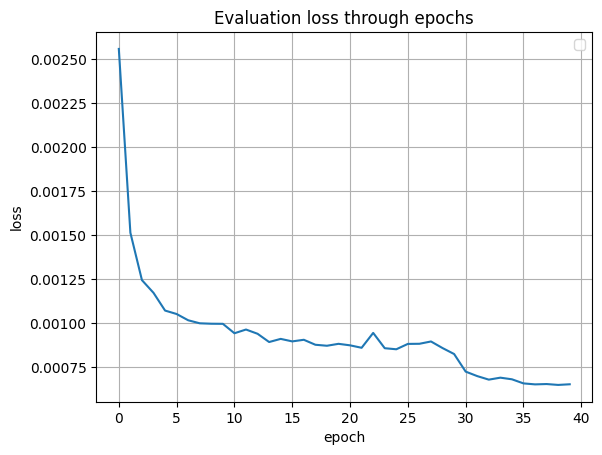

In [26]:
plot_history(history)

In [27]:
print(model)

ConvAE(
  (encoder): Encoder(
    (conv1): Conv1d(1, 32, kernel_size=(7,), stride=(2,), padding=(3,))
    (conv2): Conv1d(32, 16, kernel_size=(7,), stride=(2,), padding=(3,))
    (conv3): Conv1d(16, 8, kernel_size=(7,), stride=(2,), padding=(3,))
    (relu): ReLU(inplace=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (conv1): ConvTranspose1d(8, 16, kernel_size=(7,), stride=(2,), padding=(3,), output_padding=(1,))
    (conv3): ConvTranspose1d(16, 32, kernel_size=(7,), stride=(2,), padding=(3,), output_padding=(1,))
    (conv4): ConvTranspose1d(32, 1, kernel_size=(7,), stride=(2,), padding=(3,), output_padding=(1,))
    (relu): ReLU(inplace=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (sigmoid): Sigmoid()
  )
)


In [28]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder': model.decoder.state_dict()
            }, "checkpoints/conv_ae_lead_40.pth")

# Testing the model

In [25]:
checkpoint = torch.load("checkpoints/linear_ae_lead_40.pth")#, map_location = torch.device('cpu')) 

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder.load_state_dict(checkpoint['decoder'])
#model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [26]:
X_test, y_test = create_train_eval_sequences(test, train_window)

In [27]:
X_test.shape, y_test.shape

((331056, 72, 1), (331056, 72))

## Testing with non-overlapping windows

In [29]:
X_test, y_test = create_test_sequences(test, train_window) #creo sequenze non overlappate

In [30]:
X_test.shape, y_test.shape #non-overlapping

((4636, 72, 1), (4636, 72))

In [32]:
test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(X_test).float().view(([X_test.shape[0],w_size,1]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [33]:
results, w = testing(model, test_loader)

In [34]:
w

[tensor([[[0.3394],
          [0.2650],
          [0.2164],
          ...,
          [0.1423],
          [0.1459],
          [0.1464]],
 
         [[0.1440],
          [0.1431],
          [0.1498],
          ...,
          [0.1490],
          [0.1424],
          [0.1391]],
 
         [[0.1684],
          [0.1639],
          [0.1733],
          ...,
          [0.1436],
          [0.1437],
          [0.1440]],
 
         ...,
 
         [[0.4628],
          [0.4566],
          [0.4549],
          ...,
          [0.4635],
          [0.4534],
          [0.4461]],
 
         [[0.4605],
          [0.4669],
          [0.4727],
          ...,
          [0.4613],
          [0.4630],
          [0.4585]],
 
         [[0.4639],
          [0.4551],
          [0.4534],
          ...,
          [0.4587],
          [0.4521],
          [0.4535]]]),
 tensor([[[0.4614],
          [0.4555],
          [0.4540],
          ...,
          [0.4579],
          [0.4558],
          [0.4604]],
 
         [[0.4575]

In [35]:
len(w), w[0].size(), w[-1].size()

(37, torch.Size([128, 72, 1]), torch.Size([28, 72, 1]))

In [36]:
reconstruction=np.concatenate([torch.stack(w[:-1]).flatten().detach().cpu().numpy(),
                              w[-1].flatten().detach().cpu().numpy()])

In [37]:
reconstruction

array([0.3393715 , 0.26504055, 0.21637483, ..., 0.33590674, 0.3316163 ,
       0.33537975], dtype=float32)

In [38]:
len(reconstruction)

333792

Let's repeat the same for the

In [39]:
scaler = MinMaxScaler(feature_range=(0,1))

In [40]:
dfs_dict_1 = {}
for building_id, gdf in test.groupby("building_id"):
  gdf[['meter_reading']]=scaler.fit_transform(gdf[['meter_reading']])
  dfs_dict_1[building_id] = gdf
predicted_df_test = pd.concat(dfs_dict_1.values())

In [41]:
predicted_df_test['reconstruction'] = reconstruction

In [42]:
predicted_df_test

building_id                    primary_use  \
2016-01-01 00:00:00           69                        Parking   
2016-01-01 01:00:00           69                        Parking   
2016-01-01 02:00:00           69                        Parking   
2016-01-01 03:00:00           69                        Parking   
2016-01-01 04:00:00           69                        Parking   
...                          ...                            ...   
2016-12-31 19:00:00         1319  Entertainment/public assembly   
2016-12-31 20:00:00         1319  Entertainment/public assembly   
2016-12-31 21:00:00         1319  Entertainment/public assembly   
2016-12-31 22:00:00         1319  Entertainment/public assembly   
2016-12-31 23:00:00         1319  Entertainment/public assembly   

                     meter_reading  sea_level_pressure  is_holiday  anomaly  \
2016-01-01 00:00:00       0.350417               967.2           1        0   
2016-01-01 01:00:00       0.244752              1019.4           1        0   
2016-01-01 02:00:00       0.191920              1018.8           1        0   
2016-01-01 03:00:00       0.165504              1018.1           1        0   
2016-01-01 04:00:00       0.152296              1019.0           1        0   
...                            ...                 ...         ...      ...   
2016-12-31 19:00:00       0.336511               967.2           0        0   
2016-12-31 20:00:00       0.336511               967.2           0        0   
2016-12-31 21:00:00       0.336511               967.2           0        0   
2016-12-31 22:00:00       0.336511               967.2           0        0   
2016-12-31 23:00:00       0.336511               967.2           0        0   

                     is_na  weekday  weekday_y  weekday_x  reconstruction  
2016-01-01 00:00:00   True        4  -0.433884  -0.900969        0.339372  
2016-01-01 01:00:00   True        4  -0.433884  -0.900969        0.265041  
2016-01-01 02:00:00   True        4  -0.433884  -0.900969        0.216375  
2016-01-01 03:00:00   True        4  -0.433884  -0.900969        0.185107  
2016-01-01 04:00:00   True        4  -0.433884  -0.900969        0.157915  
...                    ...      ...        ...        ...             ...  
2016-12-31 19:00:00   True        5  -0.974928  -0.222521        0.334870  
2016-12-31 20:00:00   True        5  -0.974928  -0.222521        0.337252  
2016-12-31 21:00:00   True        5  -0.974928  -0.222521        0.335907  
2016-12-31 22:00:00   True        5  -0.974928  -0.222521        0.331616  
2016-12-31 23:00:00   True        5  -0.974928  -0.222521        0.335380  

[333792 rows x 11 columns]

In [43]:
predicted_df_test['relative_loss'] = np.abs((predicted_df_test['reconstruction']-predicted_df_test['meter_reading'])/predicted_df_test['reconstruction'])

In [44]:
#calculate threshold on relative loss quartiles but only on val, and in this case per building
thresholds=np.array([])
for building_id, gdf in predicted_df_test.groupby("building_id"):
  val_mre_loss_building= gdf['relative_loss'].values
  building_threshold = (np.percentile(val_mre_loss_building, 75)) + 1.5 *((np.percentile(val_mre_loss_building, 75))-(np.percentile(val_mre_loss_building, 25)))
  gdf['threshold']=building_threshold
  thresholds= np.append(thresholds, gdf['threshold'].values)
print(thresholds.shape)
predicted_df_test['threshold']= thresholds

(333792,)


In [45]:
predicted_df_test['predicted_anomaly'] = predicted_df_test['relative_loss'] > predicted_df_test['threshold']
predicted_df_test['predicted_anomaly']=predicted_df_test['predicted_anomaly'].replace(False,0)
predicted_df_test['predicted_anomaly']=predicted_df_test['predicted_anomaly'].replace(True,1)

In [46]:
predicted_df_test.index.names=['timestamp']
predicted_df_test= predicted_df_test.reset_index()

In [47]:
predicted_df_test.predicted_anomaly.unique()

array([0, 1])

In [48]:
predicted_anomalies = predicted_df_test.loc[predicted_df_test['predicted_anomaly'] == 1]
true_anomalies = predicted_df_test.loc[predicted_df_test['anomaly'] == 1]

In [49]:
predicted_df_test = pd.merge(predicted_df_test, df[['timestamp','building_id']], on=['timestamp','building_id'])

In [50]:
print(classification_report(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly']))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    324574
           1       0.18      0.50      0.26      7767

    accuracy                           0.93    332341
   macro avg       0.58      0.72      0.61    332341
weighted avg       0.97      0.93      0.95    332341



In [51]:
roc_auc_score(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly'])

0.7225626599402108

In [52]:
len(true_anomalies), len(predicted_anomalies)

(8663, 21813)

In [53]:
len(predicted_anomalies) / len(predicted_df_test)

0.06563439358971658

In [ ]:
predicted_df_test.building_id.unique()

In [ ]:
visualizations = predicted_df_test[predicted_df_test.building_id == 1264]
visualizations

In [ ]:
plt.plot(visualizations.meter_reading, label = "meter reading") 
plt.plot(visualizations.reconstruction, label = "w1_reconstruction")
plt.plot(visualizations.reconstruction2, label = "w2_reconstruction")
plt.legend()
plt.show()

In [ ]:
predicted_anomalies = visualizations.loc[visualizations['predicted_anomaly'] == 1]
predicted_anomalies2 = visualizations.loc[visualizations['predicted_anomaly2'] == 1]
true_anomalies = visualizations.loc[visualizations['anomaly'] == 1]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=visualizations.index, y=visualizations['meter_reading'], name='meter readings'))
fig.add_trace(go.Scatter(x=visualizations.index, y=visualizations['reconstruction'], name='w1 reconstructed'))
fig.add_trace(go.Scatter(x=visualizations.index, y=visualizations['reconstruction2'], name='w2 reconstructed'))

fig.add_trace(go.Scatter(x=true_anomalies.index, y=true_anomalies['meter_reading'], mode='markers', marker=dict(color='forestgreen'), name='True_Anomaly'))
fig.add_trace(go.Scatter(x=predicted_anomalies.index, y=predicted_anomalies['meter_reading'], mode='markers', marker=dict(color='yellow'), name='W1_Anomaly'))
fig.add_trace(go.Scatter(x=predicted_anomalies2.index, y=predicted_anomalies2['meter_reading'], mode='markers', marker=dict(color='orange'), name='W2_Anomaly'))
fig.update_layout(showlegend=True, title='meter readings predicted and anomalies - val')
fig.show()

# Testing the model (overlapping windows; anomaly score-based)

In [54]:
X_test, y_test = create_train_eval_sequences(test, train_window)

In [55]:
X_test.shape, y_test.shape

((331056, 72, 1), (331056, 72))

In [57]:
test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(X_test).float().view(([X_test.shape[0],w_size,1]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [59]:
results, w=testing(model,test_loader) #Prova con il test set #in cpu ci mette 4 secondi (modello con 40 epoch)

In [60]:
results

[tensor([[1.0854e-04],
         [8.2307e-05],
         [1.8843e-04],
         [5.9323e-05],
         [4.6405e-05],
         [5.8609e-05],
         [7.2087e-05],
         [9.2705e-05],
         [1.1177e-04],
         [9.0305e-05],
         [5.1346e-05],
         [5.5395e-05],
         [5.2046e-05],
         [7.1384e-05],
         [2.0021e-04],
         [7.4561e-05],
         [4.4904e-05],
         [8.0809e-05],
         [7.7217e-05],
         [5.3412e-05],
         [5.7789e-05],
         [1.5065e-04],
         [6.6077e-05],
         [6.4064e-05],
         [6.7170e-05],
         [1.0964e-04],
         [6.3742e-05],
         [5.6152e-05],
         [6.5568e-05],
         [7.0200e-05],
         [2.5377e-04],
         [1.5833e-04],
         [9.3182e-05],
         [6.2239e-05],
         [1.1586e-04],
         [2.9737e-04],
         [4.3426e-05],
         [6.0808e-05],
         [1.1086e-04],
         [7.4789e-05],
         [9.4400e-05],
         [7.3854e-05],
         [7.2514e-05],
         [1

In [61]:
labels = test.anomaly.values

In [62]:
# Qui va ad ottenere le label per ogni finestra
# Input modello è una lista di array, ognuno corrispondente a una sliding window con stride = 1 sui dati originali
# Quindi dobbiamo applicare la sliding window anche sulle label
windows_labels=[]
for b_id, gdf in test.groupby('building_id'):
    labels = gdf.anomaly.values
    for i in range(len(labels)-train_window):
        windows_labels.append(list(np.int_(labels[i:i+train_window])))
windows_labels

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [63]:
len(windows_labels)

331056

In [64]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

In [65]:
np.sum(y_test)

53736.0

In [66]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

In [67]:
len(y_test), len(y_pred)

(331056, 331056)

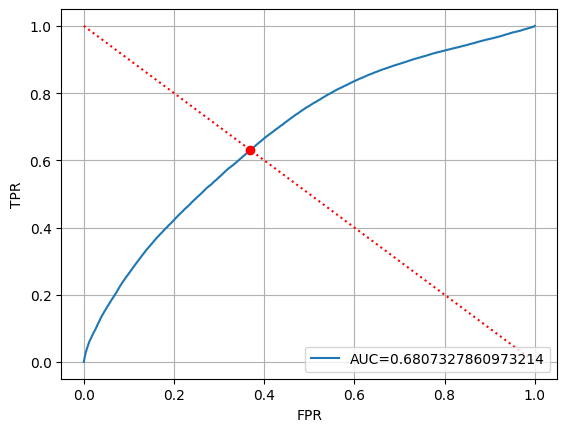

In [68]:
threshold=ROC(y_test,y_pred)

In [69]:
y_pred_ = np.zeros(y_pred.shape[0])
y_pred_[y_pred >= threshold] = 1

In [70]:
roc_auc_score(y_test, y_pred_)

0.6305346773787803

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [72]:
cm = confusion_matrix(y_test, y_pred_)

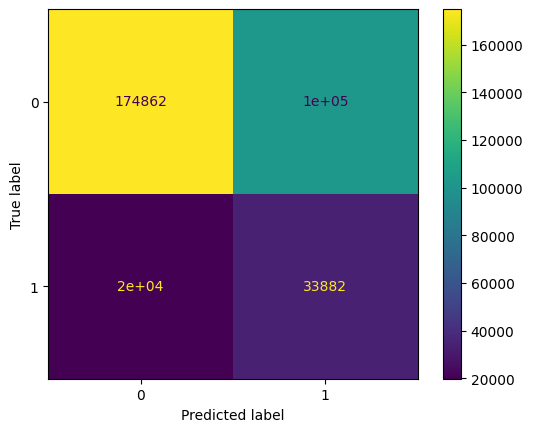

In [73]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [74]:
print(classification_report(y_test, y_pred_))

              precision    recall  f1-score   support

         0.0       0.90      0.63      0.74    277320
         1.0       0.25      0.63      0.36     53736

    accuracy                           0.63    331056
   macro avg       0.57      0.63      0.55    331056
weighted avg       0.79      0.63      0.68    331056



In [78]:
threshold = np.percentile(y_pred, 80)
print(threshold)
y_pred_ = np.zeros(y_pred.shape[0])
y_pred_[y_pred >= threshold] = 1

0.0005121362046338618


In [79]:
print(classification_report(y_test, y_pred_))

              precision    recall  f1-score   support

         0.0       0.87      0.83      0.85    277320
         1.0       0.30      0.38      0.34     53736

    accuracy                           0.76    331056
   macro avg       0.59      0.60      0.59    331056
weighted avg       0.78      0.76      0.77    331056



In [80]:
roc_auc_score(y_test, y_pred_)

0.6046421703503327

# Testing the model (overlapping windows; reconstruction-based)

In [ ]:
results, w1, w2 = testing_prova(model, test_loader)

In [ ]:
w1

In [ ]:
w2

In [ ]:
# CELLA DA FAR GIRARE SE SI STA USANDO usad_conv
w1_new = [torch.reshape(w1_el, (w1_el.size()[0], w1_el.size()[1])) for w1_el in w1]
w2_new = [torch.reshape(w2_el, (w2_el.size()[0], w2_el.size()[1])) for w2_el in w2]

In [ ]:
w1

In [ ]:
padded_w1 = padding_w(w1_new, BATCH_SIZE) # Se si usa usad, non convoluzionale, mettere w1 al posto di w1_new

In [ ]:
padded_w2 = padding_w(w2_new, BATCH_SIZE) # Se si usa usad, non convoluzionale, mettere w2 al posto di w2_new

In [ ]:
reconstruction1 = apply_reconstruction(padded_w1, test.building_id.nunique())

In [ ]:
reconstruction2 = apply_reconstruction(padded_w2, test.building_id.nunique())

## Reconstruction (overlapping; w1,w2-based)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
dfs_dict_1 = {}
for building_id, gdf in test.groupby("building_id"):
  gdf[['meter_reading']]=scaler.fit_transform(gdf[['meter_reading']])
  dfs_dict_1[building_id] = gdf
predicted_df_test = pd.concat(dfs_dict_1.values())

In [ ]:
predicted_df_test['reconstruction'] = reconstruction1

In [ ]:
predicted_df_test['reconstruction2'] = reconstruction2

In [ ]:
predicted_df_test

In [ ]:
predicted_df_test['reconstruction']=predicted_df_test['reconstruction'].replace(np.nan,0)

In [ ]:
predicted_df_test['reconstruction2']=predicted_df_test['reconstruction2'].replace(np.nan,0)

In [ ]:
predicted_df_test

In [ ]:
predicted_df_test.reconstruction2.min(), predicted_df_test.reconstruction2.max()

In [ ]:
predicted_df_test['relative_loss'] = np.abs((predicted_df_test['reconstruction']-predicted_df_test['meter_reading'])/predicted_df_test['reconstruction'])

In [ ]:
predicted_df_test['relative_loss2'] = np.abs((predicted_df_test['reconstruction2']-predicted_df_test['meter_reading'])/predicted_df_test['reconstruction2'])

In [ ]:
#calculate threshold on relative loss quartiles but only on val, and in this case per building
thresholds=np.array([])
for building_id, gdf in predicted_df_test.groupby("building_id"):
  val_mre_loss_building= gdf['relative_loss'].values
  building_threshold = (np.percentile(val_mre_loss_building, 75)) + 1.5 *((np.percentile(val_mre_loss_building, 75))-(np.percentile(val_mre_loss_building, 25)))
  gdf['threshold']=building_threshold
  thresholds= np.append(thresholds, gdf['threshold'].values)
print(thresholds.shape)
predicted_df_test['threshold']= thresholds

In [ ]:
#calculate threshold on relative loss quartiles but only on val, and in this case per building
thresholds=np.array([])
for building_id, gdf in predicted_df_test.groupby("building_id"):
  val_mre_loss_building= gdf['relative_loss2'].values
  building_threshold = (np.percentile(val_mre_loss_building, 75)) + 1.5 *((np.percentile(val_mre_loss_building, 75))-(np.percentile(val_mre_loss_building, 25)))
  gdf['threshold2']=building_threshold
  thresholds= np.append(thresholds, gdf['threshold2'].values)
print(thresholds.shape)
predicted_df_test['threshold2']= thresholds

In [ ]:
predicted_df_test

In [ ]:
predicted_df_test['predicted_anomaly'] = predicted_df_test['relative_loss'] > predicted_df_test['threshold']
predicted_df_test['predicted_anomaly']=predicted_df_test['predicted_anomaly'].replace(False,0)
predicted_df_test['predicted_anomaly']=predicted_df_test['predicted_anomaly'].replace(True,1)

In [ ]:
predicted_df_test['predicted_anomaly2'] = predicted_df_test['relative_loss2'] > predicted_df_test['threshold2']
predicted_df_test['predicted_anomaly2']=predicted_df_test['predicted_anomaly2'].replace(False,0)
predicted_df_test['predicted_anomaly2']=predicted_df_test['predicted_anomaly2'].replace(True,1)

In [ ]:
predicted_df_test.index.names=['timestamp']
predicted_df_test= predicted_df_test.reset_index()

In [ ]:
predicted_df_test.predicted_anomaly.unique()

In [ ]:
predicted_df_test.predicted_anomaly2.unique()

In [ ]:
predicted_df_test.predicted_anomaly.sum() / len(predicted_df_test), predicted_df_test.predicted_anomaly2.sum() / len(predicted_df_test)

In [ ]:
predicted_anomalies = predicted_df_test.loc[predicted_df_test['predicted_anomaly'] == 1]
predicted_anomalies2 = predicted_df_test.loc[predicted_df_test['predicted_anomaly2'] == 1]
true_anomalies = predicted_df_test.loc[predicted_df_test['anomaly'] == 1]

In [ ]:
len(predicted_anomalies) / len(predicted_df_test), len(predicted_anomalies2) / len(predicted_df_test)

In [ ]:
predicted_df_test = pd.merge(predicted_df_test, df[['timestamp','building_id']], on=['timestamp','building_id'])

In [ ]:
print(classification_report(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly']))

In [ ]:
print(classification_report(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly2']))

In [ ]:
roc_auc_score(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly'])

In [ ]:
roc_auc_score(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly2'])

In [ ]:
predicted_df_test.building_id.unique()

In [ ]:
visualizations = predicted_df_test[predicted_df_test.building_id == 994]
visualizations

In [ ]:
plt.plot(visualizations.meter_reading, label = "meter reading") #predicted_df_test.meter_reading[:8784]
plt.plot(visualizations.reconstruction, label = "w1_reconstruction")
plt.plot(visualizations.reconstruction2, label = "w2_reconstruction")
plt.legend()
plt.show()

In [ ]:
predicted_anomalies = visualizations.loc[visualizations['predicted_anomaly'] == 1]
predicted_anomalies2 = visualizations.loc[visualizations['predicted_anomaly2'] == 1]
true_anomalies = visualizations.loc[visualizations['anomaly'] == 1]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=visualizations.index, y=visualizations['meter_reading'], name='meter readings'))
fig.add_trace(go.Scatter(x=visualizations.index, y=visualizations['reconstruction'], name='w1 reconstructed'))
fig.add_trace(go.Scatter(x=visualizations.index, y=visualizations['reconstruction2'], name='w2 reconstructed'))

fig.add_trace(go.Scatter(x=true_anomalies.index, y=true_anomalies['meter_reading'], mode='markers', marker=dict(color='forestgreen'), name='True_Anomaly'))
fig.add_trace(go.Scatter(x=predicted_anomalies.index, y=predicted_anomalies['meter_reading'], mode='markers', marker=dict(color='yellow'), name='W1_Anomaly'))
fig.add_trace(go.Scatter(x=predicted_anomalies2.index, y=predicted_anomalies2['meter_reading'], mode='markers', marker=dict(color='orange'), name='W2_Anomaly'))
fig.update_layout(showlegend=True, title='meter readings predicted and anomalies - val')
fig.show()

In [ ]:
len(true_anomalies), len(predicted_anomalies), len(predicted_anomalies2)